# Tensorflow for Facial Recognition

We're going to create a recogntion sysem for the members of Destiny's child using a combination of the `face_recognition` package and tensorflow.

`face_recognition` will give us our initial bounding boxes for faces, while tensorflow allows us to train and classify each face as one (or none) of the three members.

1. Loading the Dataset

I've already extracted faces from many of the videos on their Youtube channel. Let's load them:

In [ ]:
# authenticate google if you want and save things to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir -p /content/drive/MyDrive/tensorflow_facial_recognition_output_FINAL
MODEL_SAVE_DIR = "/content/drive/MyDrive/tensorflow_facial_recognition_output_FINAL"

## 1. Creating the Dataset


In [ ]:
!gdown https://drive.google.com/uc?id=1bhR5WTXID9kTxlMmgbKwf3t8-PQUIbTo
!unzip -q /content/destinys_child_data.zip

Downloading...
From: https://drive.google.com/uc?id=1bhR5WTXID9kTxlMmgbKwf3t8-PQUIbTo
To: /content/destinys_child_data.zip
769MB [00:06, 114MB/s] 


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3841519320640070280, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701340352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3612598457950357902
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [ ]:
!ls -R /content/destinys_child_data

/content/destinys_child_data:
compressed  raw  test  train

/content/destinys_child_data/compressed:
8_Days_of_Christmas_compressed.mp4	 Lose_My_Breath_compressed.mp4
Bills_Bills_Bills_compressed.mp4	 Me_Myself_and_I_compressed.mp4
Bootylicious_compressed.mp4		 Nasty_Girl_compressed.mp4
Bug_A_Boo_compressed.mp4		 No_No_No_compressed.mp4
Cater_2_U_compressed.mp4		 Say_My_Name_compressed.mp4
Emotion_compressed.mp4			 Soldier_compressed.mp4
Get_On_The_Bus_compressed.mp4		 Stand_Up_For_Love_compressed.mp4
Independent_Women_Part_1_compressed.mp4  Survivor_compressed.mp4
Jumpin_Jumpin_compressed.mp4		 With_Me_Part_1_compressed.mp4

/content/destinys_child_data/raw:
8_Days_of_Christmas.mp4  Get_On_The_Bus.mp4	       Say_My_Name.mp4
Bills_Bills_Bills.mp4	 Independent_Women_Part_1.mp4  Soldier.mp4
Bootylicious.mp4	 Jumpin_Jumpin.mp4	       Stand_Up_For_Love.mp4
Bug_A_Boo.mp4		 Lose_My_Breath.mp4	       Survivor.mp4
Cater_2_U.mp4		 Me_Myself_and_I.mp4	       With_Me_Part_1.mp4
compressed		 Nasty

In [ ]:
! pip install tensorflow_addons face_recognition

### Imports

We need to import `tensorflow` for our models.

We'll set run_functions_eagerly to be true, as it allows for evaluation of tensors directly. See [here](https://www.tensorflow.org/guide/eager) if you're intersted.

We'll also be using the `keras` submodule in `tensorflow`, which was once its own library, but is now a part of tensorflow, and allows for quick definition of machine learning models.

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_addons as tfa
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import cv2
import face_recognition
import os
import numpy as np
import tqdm


Datasets can be loaded using pre-define keras datasets, or custom datasets using the keras definition of an image dataset from a directory.

See the documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) and [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing) for pre-defined and custom datasets with keras.

The directory structure for custom image datasets is expected to be as follows:
```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

To make it simple, we'll load separate datasets for train and test.


Found 2335 files belonging to 4 classes.
Found 366 files belonging to 4 classes.
['beyonce', 'kelly', 'michelle', 'unknown'] ['beyonce', 'kelly', 'michelle', 'unknown']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Random Ratio: Beyonce (0.4166666666666667), Kelly (0.1388888888888889), Michelle (0.1111111111111111), Unknown (0.3333333333333333)


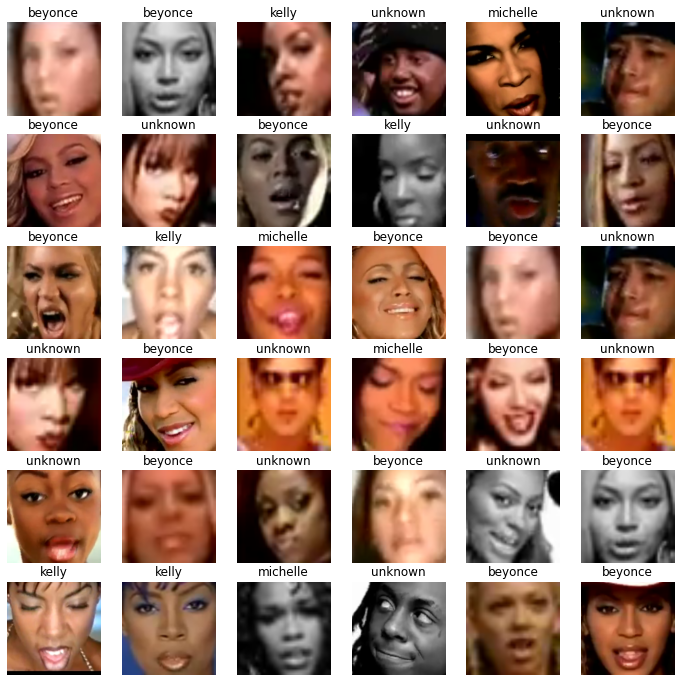

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    '/content/destinys_child_data/train', labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(224,
    224), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    '/content/destinys_child_data/test', labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=1, image_size=(224,
    224), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False, 
)
class_names_train = train_ds.class_names
class_names_test = test_ds.class_names
print(class_names_train, class_names_test)
class_names = class_names_train
fig, axs = plt.subplots(6, 6, figsize=(12, 12))
count_beyonce = 0
count_kelly = 0
count_michelle = 0
count_unknown = 0
for i in range(6):
  for j in range(6):
    for images, labels in train_ds.take(1):
      if labels[0] == 0:
        count_beyonce += 1
      elif labels[0] == 1:
        count_kelly += 1
      elif labels[0] == 2:
        count_michelle += 1
      elif labels[0] == 3:
        count_unknown += 1
      ax = axs[i, j]
      ax.imshow(images[0].numpy().squeeze().astype("uint8"))
      ax.set_title(class_names[labels[0].numpy().squeeze()])
      ax.axis('off')

print('Random Ratio: Beyonce ({}), Kelly ({}), Michelle ({}), Unknown ({})'
      .format(count_beyonce/36., count_kelly/36., count_michelle/36., count_unknown/36.))
plt.show()

## 2. Model Design

We'll use the [`keras_vggface` library ](https://github.com/rcmalli/keras-vggface)to use the `VGGFace` pre-trained model.

This model is trained on over 2k faces, so we'll just take the encoder and by setting `include_top=False` and create our own classifier using `keras` `Dense` layers.

In [ ]:
! pip install keras_vggface keras_applications

In [ ]:
from keras_vggface import VGGFace
from keras import Model
from keras.layers import Dense, Flatten


class RecognitionModel(Model):
  def __init__(self, input_len=224, classes=len(class_names)):
    super(RecognitionModel, self).__init__()
    self.vggface = VGGFace(include_top=False, model='vgg16', weights='vggface', 
              input_tensor=None, input_shape=(input_len, input_len, 3), pooling=None,
              classes=classes)
    self.flatten = Flatten()
    self.d1 = Dense(8192, activation='relu')
    self.d2 = Dense(1024, activation='relu')
    self.dc = Dense(classes)

  def call(self, x):
    x = self.vggface(x)
    x = self.flatten(x)
    x = self.dc(self.d2(self.d1(x)))
    return x



For training, we first need to evaluate the model, which returns `logits`, which are log probabliities for each class. From there, we turn those log probabilities into percentages, and if that percentage is grater than 50%, we classify it as a face during training. 

During evaluation, we simply take the highest predicted class, as we know only a single face will show up in each image.

We'll use stochastic gradient descent as our optimizer, and cross entropy loss, which penalizes incorrect class labels for multi-class classification. We'll use the sparse version, so that our loss will take in a vector of probabilities on each class rather than a single class label.

In [ ]:
# create loss and optimizer
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.SGD(lr=0.001)

# train/test loss and accuracy
train_loss = tf.keras.metrics.Mean(name='loss')
train_accuracy = tf.keras.metrics.Accuracy(name='acc')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
model_full = RecognitionModel()
model_full.build(input_shape=(None, 224, 224, 3))
# train and test single steps

In [ ]:
@tf.function
def train_step(images, labels):
  one_hot_labels = tf.one_hot(labels, depth=len(class_names))
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    logits = model_full(images, training=True)
    sfmax = tf.nn.softmax(logits, axis=-1)
    predictions = tf.cast(tf.greater_equal(sfmax, 0.5), tf.int64)
    predictions = tf.one_hot(tf.argmax(predictions, axis=-1), depth=len(class_names))
    loss = loss_object(labels, sfmax)
  gradients = tape.gradient(loss, model_full.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model_full.trainable_variables))
  
  train_loss(loss)
  train_accuracy(one_hot_labels, predictions)
  return tf.argmax(predictions, axis=-1)

@tf.function
def test_step(test_images, test_labels):
  one_hot_labels = tf.one_hot(test_labels, depth=len(class_names))
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model_full(test_images, training=False)
  sfmax = tf.nn.softmax(logits, axis=-1)
  predictions = tf.cast(tf.greater_equal(sfmax, 0.5), tf.int64)
  predictions = tf.one_hot(tf.argmax(predictions, axis=-1), depth=len(class_names))
  t_loss = loss_object(test_labels, sfmax)
  test_loss(t_loss)
  test_accuracy(one_hot_labels, predictions)
  return predictions

In [ ]:
EPOCHS = 25
with tf.device('/GPU:0'):
  for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
      predictions = train_step(images, labels)

    for test_images, test_labels in test_ds:
      tpredictions = test_step(test_images, test_labels)
                               
      
    #print(tpredictions)
    print(
      f'Epoch {epoch + 1}, '
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result() * 100}%, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result() * 100}%'
    )


Epoch 1, Loss: 2.040069341659546, Accuracy: 72.11991882324219%, Test Loss: 1.0385427474975586, Test Accuracy: 76.36611938476562%
Epoch 2, Loss: 0.67375248670578, Accuracy: 84.13275909423828%, Test Loss: 0.7460718154907227, Test Accuracy: 84.5628433227539%
Epoch 3, Loss: 0.34386321902275085, Accuracy: 92.37687683105469%, Test Loss: 1.0982334613800049, Test Accuracy: 83.7431640625%
Epoch 4, Loss: 0.14935100078582764, Accuracy: 97.5374755859375%, Test Loss: 1.1763272285461426, Test Accuracy: 85.6557388305664%
Epoch 5, Loss: 0.051153115928173065, Accuracy: 99.50749206542969%, Test Loss: 0.8571162223815918, Test Accuracy: 89.07103729248047%
Epoch 6, Loss: 0.020675793290138245, Accuracy: 99.89292907714844%, Test Loss: 0.979875922203064, Test Accuracy: 88.38797760009766%
Epoch 7, Loss: 0.010889063589274883, Accuracy: 99.93576049804688%, Test Loss: 0.941364049911499, Test Accuracy: 88.66120147705078%
Epoch 8, Loss: 0.00647730240598321, Accuracy: 99.97858428955078%, Test Loss: 0.967413067817688

Lets look at accuracy accross each class.

In [ ]:
train_ds_1 = keras.preprocessing.image_dataset_from_directory(
    '/content/destinys_child_data/train', labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=1, image_size=(224,
    224), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

Found 2335 files belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
all_stat_classes = class_names
all_stat_classes.append('total')
stats_full = {
    ds_type: {
      'accuracy': {
          c_: 0.0 for c_ in all_stat_classes
      },
      'total': {
          c_: 0 for c_ in all_stat_classes
      }
    }
    for ds_type in ['train', 'test']
}
with tf.device('/GPU:0'):
  for ds_type, curr_ds in [('train', train_ds_1), ('test', test_ds)]:
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images, labels in curr_ds:
      stats_full[ds_type]['total']['total'] += 1
      one_hot = test_step(images, labels)
      prediction = np.argmax(one_hot)
      pred_name = class_names[prediction]
      truth = class_names[labels[0]]
      stats_full[ds_type]['total'][truth] += 1
      if pred_name == truth:
        stats_full[ds_type]['accuracy']['total'] += 1
        stats_full[ds_type]['accuracy'][pred_name] += 1

In [ ]:
print(stats_full)

{'train': {'accuracy': {'beyonce': 908.0, 'kelly': 432.0, 'michelle': 326.0, 'unknown': 669.0, 'total': 2335.0}, 'total': {'beyonce': 908, 'kelly': 432, 'michelle': 326, 'unknown': 669, 'total': 2335}}, 'test': {'accuracy': {'beyonce': 152.0, 'kelly': 58.0, 'michelle': 48.0, 'unknown': 32.0, 'total': 290.0}, 'total': {'beyonce': 172, 'kelly': 86, 'michelle': 68, 'unknown': 40, 'total': 366}}}


We can see that using this unbalanced dataset, some classes suffer more than others.

[1.0, 1.0, 1.0, 1.0] [0.8837209302325582, 0.6744186046511628, 0.7058823529411765, 0.8]


Text(0.5, 1.0, 'Unbalanced Dataset: Accuracy Comparison')

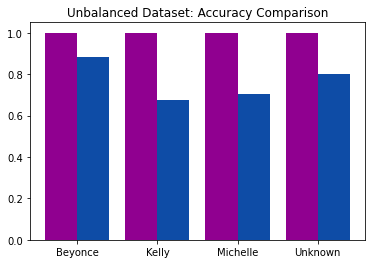

In [ ]:
train_comparisons = [
                    stats_full['train']['accuracy']['beyonce']/stats_full['train']['total']['beyonce'], 
                    stats_full['train']['accuracy']['kelly']/stats_full['train']['total']['kelly'], 
                    stats_full['train']['accuracy']['michelle']/stats_full['train']['total']['michelle'], 
                    stats_full['train']['accuracy']['unknown']/stats_full['train']['total']['unknown'],
]
test_comparisons = [
                    stats_full['test']['accuracy']['beyonce']/stats_full['test']['total']['beyonce'], 
                    stats_full['test']['accuracy']['kelly']/stats_full['test']['total']['kelly'], 
                    stats_full['test']['accuracy']['michelle']/stats_full['test']['total']['michelle'], 
                    stats_full['test']['accuracy']['unknown']/stats_full['test']['total']['unknown'],
]

print(train_comparisons, test_comparisons)

fig, ax = plt.subplots()
ax.bar([-0.2, 0.8, 1.8, 2.8], train_comparisons, width=0.4, color='#900090', label='train', )
ax.bar([0.2, 1.2, 2.2, 3.2], test_comparisons, width=0.4, color='#0E4CA6', label='test')
ax.set_xticklabels(['Beyonce', 'Kelly', 'Michelle', 'Unknown'])
ax.set_xticks([0, 1, 2, 3])
ax.set_title('Unbalanced Dataset: Accuracy Comparison')

Will a randomly balanced dataset solve this?

In [ ]:
# distributed dataset
! rm -rf /content/destinys_child_data_balanced/
! mkdir -p /content/destinys_child_data_balanced/train/beyonce
! mkdir /content/destinys_child_data_balanced/train/kelly
! mkdir /content/destinys_child_data_balanced/train/michelle
! mkdir /content/destinys_child_data_balanced/train/unknown
! mkdir -p /content/destinys_child_data_balanced/test/beyonce
! mkdir /content/destinys_child_data_balanced/test/kelly
! mkdir /content/destinys_child_data_balanced/test/michelle
! mkdir /content/destinys_child_data_balanced/test/unknown

def create_balanced_dataset(train=True):
  beyonce_base = '/content/destinys_child_data/{}/beyonce'.format('train' if train else 'test')
  kelly_base = '/content/destinys_child_data/{}/kelly'.format('train' if train else 'test')
  michelle_base = '/content/destinys_child_data/{}/michelle'.format('train' if train else 'test')
  unk_base = '/content/destinys_child_data/{}/unknown'.format('train' if train else 'test')
  all_beyonce = [os.path.join(beyonce_base, f) for f in os.listdir(beyonce_base) if f.split('.')[-1] == 'png']
  all_kelly = [os.path.join(kelly_base, f) for f in os.listdir(kelly_base) if f.split('.')[-1] == 'png']
  all_michelle = [os.path.join(michelle_base, f) for f in os.listdir(michelle_base) if f.split('.')[-1] == 'png']
  all_unk = [os.path.join(unk_base, f) for f in os.listdir(unk_base) if f.split('.')[-1] == 'png']

  print(len(all_beyonce), len(all_kelly), len(all_michelle), len(all_unk))
  scale = 1
  total = int(np.mean([len(all_beyonce), len(all_kelly), len(all_michelle), len(all_unk)]))
  print(total)

  selected_beyonce = np.random.choice(list(range(len(all_beyonce))), replace=False, size=min(len(all_beyonce), total))
  selected_kelly  = np.random.choice(list(range(len(all_kelly))) , replace=False, size=min(len(all_kelly), total))
  selected_michelle = np.random.choice(list(range(len(all_michelle))), replace=False, size=min(len(all_michelle), total))
  selected_unk = np.random.choice(list(range(len(all_unk))), replace=False, size=min(len(all_unk), total))

  print(len(selected_beyonce), len(selected_kelly), len(selected_michelle), len(selected_unk))

  beyonce_base = '/content/destinys_child_data_balanced/{}/beyonce'.format('train' if train else 'test')
  kelly_base = '/content/destinys_child_data_balanced/{}/kelly'.format('train' if train else 'test')
  michelle_base = '/content/destinys_child_data_balanced/{}/michelle'.format('train' if train else 'test')
  unk_base = '/content/destinys_child_data_balanced/{}/unknown'.format('train' if train else 'test')

  for i in selected_beyonce:
    os.system('cp {} {}/.'.format(all_beyonce[i], beyonce_base))
  for i in selected_kelly:
    os.system('cp {} {}/.'.format(all_kelly[i], kelly_base))
  for i in selected_michelle:
    os.system('cp {} {}/.'.format(all_michelle[i], michelle_base))
  for i in selected_unk:
    os.system('cp {} {}/.'.format(all_unk[i], unk_base))

create_balanced_dataset(True)
create_balanced_dataset(False)

908 432 326 669
583
583 432 326 583
172 86 68 40
91
91 86 68 40


In [ ]:
ls -R /content/destinys_child_data_balanced/train/beyonce | wc -l

584


Found 1924 files belonging to 4 classes.
Found 285 files belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


['beyonce', 'kelly', 'michelle', 'unknown'] ['beyonce', 'kelly', 'michelle', 'unknown']
Random Ratio: Beyonce (0.1111111111111111), Kelly (0.1111111111111111), Michelle (0.08333333333333333), Unknown (0.1388888888888889)


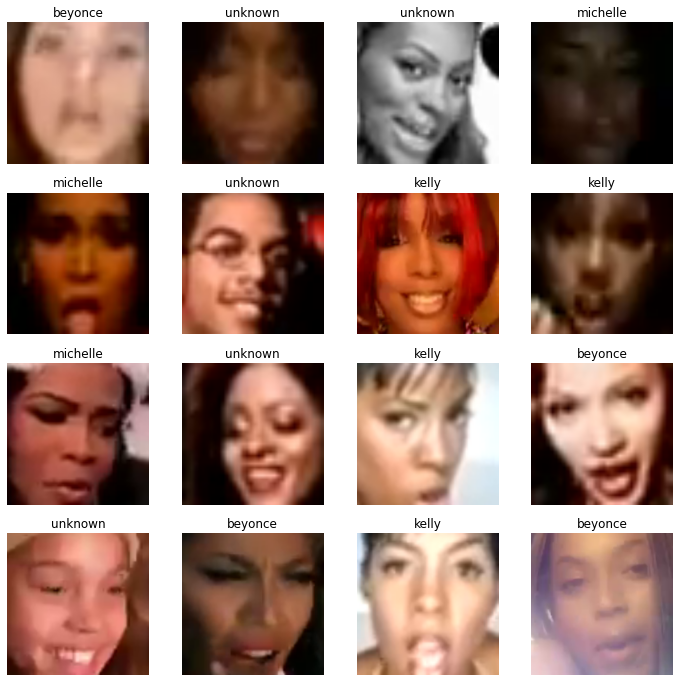

In [ ]:
train_ds_balanced = keras.preprocessing.image_dataset_from_directory(
    '/content/destinys_child_data_balanced/train', labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(224,
    224), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False, 
)


test_ds_balanced = keras.preprocessing.image_dataset_from_directory(
    '/content/destinys_child_data_balanced/test', labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=8, image_size=(224,
    224), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False, 
)
class_names_train = train_ds_balanced.class_names
class_names_test = test_ds_balanced.class_names
print(class_names_train, class_names_test)
class_names = class_names_train
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
count_beyonce = 0
count_kelly = 0
count_michelle = 0
count_unknown = 0
for i in range(4):
  for j in range(4):
    for images, labels in train_ds_balanced.take(1):
      if labels[0] == 0:
        count_beyonce += 1
      elif labels[0] == 1:
        count_kelly += 1
      elif labels[0] == 2:
        count_michelle += 1
      elif labels[0] == 3:
        count_unknown += 1
      ax = axs[i, j]
      ax.imshow(images[0].numpy().squeeze().astype("uint8"))
      ax.set_title(class_names[labels[0].numpy().squeeze()])
      ax.axis('off')

print('Random Ratio: Beyonce ({}), Kelly ({}), Michelle ({}), Unknown ({})'
      .format(count_beyonce/36., count_kelly/36., count_michelle/36., count_unknown/36.))
plt.show()

In [ ]:
model_balanced = RecognitionModel()
model_balanced.build(input_shape=(None, 224, 224, 3))

# create loss and optimizer
loss_object_balanced = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.SGD(lr=0.0001)

# train/test loss and accuracy
train_loss_balanced = tf.keras.metrics.Mean(name='loss')
train_accuracy_balanced  = tf.keras.metrics.Accuracy(name='acc')
test_loss_balanced  = tf.keras.metrics.Mean(name='test_loss')
test_accuracy_balanced  = tf.keras.metrics.Accuracy(name='test_accuracy')

In [ ]:
# train and test single steps
@tf.function
def train_step_balanced(images, labels):
  one_hot_labels = tf.one_hot(labels, depth=len(class_names))
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    logits = model_balanced(images, training=True)
    sfmax = tf.nn.softmax(logits, axis=-1)
    predictions = tf.cast(tf.greater_equal(sfmax, 0.5), tf.int64)
    predictions = tf.one_hot(tf.argmax(predictions, axis=-1), depth=len(class_names))
    loss = loss_object_balanced(labels, sfmax)
  gradients = tape.gradient(loss, model_balanced.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model_balanced.trainable_variables))
  
  train_loss_balanced (loss)
  train_accuracy_balanced (one_hot_labels, predictions)
  return tf.argmax(predictions, axis=-1)


@tf.function
def test_step_balanced(test_images, test_labels):
  one_hot_labels = tf.one_hot(test_labels, depth=len(class_names))
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model_balanced(test_images, training=False)
  sfmax = tf.nn.softmax(logits, axis=-1)
  predictions = tf.cast(tf.greater_equal(sfmax, 0.5), tf.int64)
  predictions = tf.one_hot(tf.argmax(predictions, axis=-1), depth=len(class_names))
  t_loss = loss_object_balanced(test_labels, sfmax)
  test_loss_balanced (t_loss)
  test_accuracy_balanced (one_hot_labels, predictions)
  return predictions

In [ ]:
EPOCHS = 25
with tf.device('/GPU:0'):
  for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss_balanced.reset_states()
    train_accuracy_balanced.reset_states()
    test_loss_balanced.reset_states()
    test_accuracy_balanced.reset_states()

    for images, labels in train_ds_balanced:
      predictions = train_step_balanced(images, labels)

    for test_images, test_labels in test_ds_balanced:
      tpredictions = test_step_balanced(test_images, test_labels)
                               
    
    #print(tpredictions)
    print(
      f'Epoch {epoch + 1}, '
      f'Loss: {train_loss_balanced.result()}, '
      f'Accuracy: {train_accuracy_balanced.result() * 100}%, '
      f'Test Loss: {test_loss_balanced.result()}, '
      f'Test Accuracy: {test_accuracy_balanced.result() * 100}%'
    )
    

Epoch 1, Loss: 3.021760940551758, Accuracy: 76.8451156616211%, Test Loss: 1.7087851762771606, Test Accuracy: 81.40350341796875%
Epoch 2, Loss: 0.4849728047847748, Accuracy: 92.48960876464844%, Test Loss: 1.2255643606185913, Test Accuracy: 86.14035034179688%
Epoch 3, Loss: 0.16641923785209656, Accuracy: 97.34927368164062%, Test Loss: 1.1266694068908691, Test Accuracy: 86.84210968017578%
Epoch 4, Loss: 0.07704386115074158, Accuracy: 99.09043884277344%, Test Loss: 1.158352255821228, Test Accuracy: 86.84210968017578%
Epoch 5, Loss: 0.04967370629310608, Accuracy: 99.74012756347656%, Test Loss: 1.164398431777954, Test Accuracy: 87.01753997802734%
Epoch 6, Loss: 0.03740270435810089, Accuracy: 99.84407043457031%, Test Loss: 1.1889262199401855, Test Accuracy: 86.31578826904297%
Epoch 7, Loss: 0.03098272532224655, Accuracy: 99.89604949951172%, Test Loss: 1.162935733795166, Test Accuracy: 87.19298553466797%
Epoch 8, Loss: 0.027334220707416534, Accuracy: 99.89604949951172%, Test Loss: 1.1634848117

In [ ]:
train_ds_balanced_1 = keras.preprocessing.image_dataset_from_directory(
    '/content/destinys_child_data_balanced/train', labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=1, image_size=(224,
    224), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)
stats_balanced = {
    ds_type: {
      'accuracy': {
          c_: 0.0 for c_ in all_stat_classes
      },
      'total': {
          c_: 0 for c_ in all_stat_classes
      }
    }
    for ds_type in ['train', 'test']
}
with tf.device('/GPU:0'):
  for ds_type, curr_ds in [('train', train_ds_balanced_1), ('test', test_ds)]:
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images, labels in curr_ds:
      stats_balanced[ds_type]['total']['total'] += 1
      one_hot = test_step_balanced(images, labels)
      prediction = np.argmax(one_hot)
      pred_name = class_names[prediction]
      truth = class_names[labels[0]]
      stats_balanced[ds_type]['total'][truth] += 1
      if pred_name == truth:
        stats_balanced[ds_type]['accuracy']['total'] += 1
        stats_balanced[ds_type]['accuracy'][pred_name] += 1

Found 1924 files belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Accuracy semed to even out a bit, and slightly increased overall.

[1.0, 1.0, 1.0, 1.0] [0.8837209302325582, 0.6744186046511628, 0.7058823529411765, 0.8]
[1.0, 1.0, 0.9969325153374233, 1.0] [0.8023255813953488, 0.686046511627907, 0.7352941176470589, 0.7]


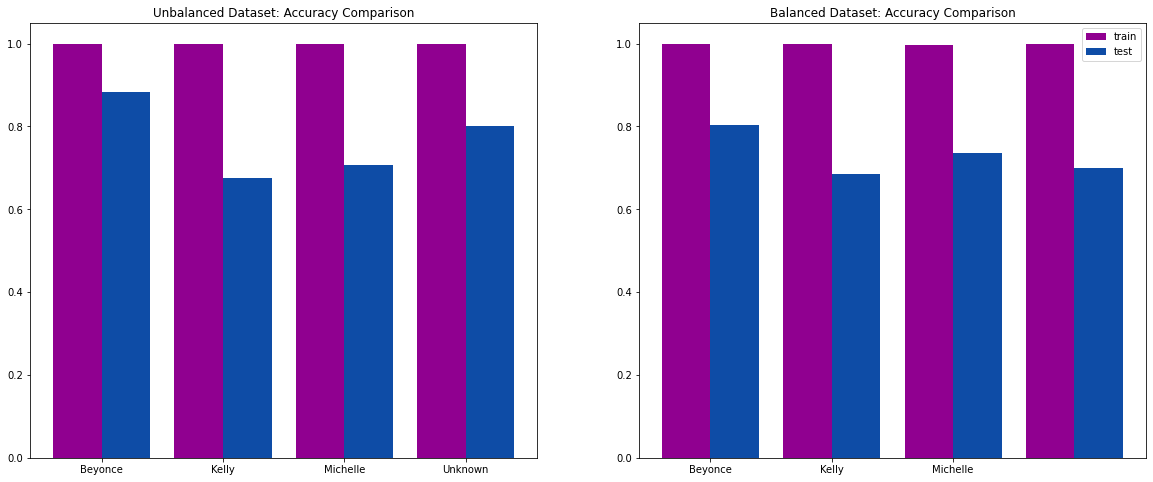

In [ ]:
train_comparisons_balanced = [
                    stats_balanced['train']['accuracy']['beyonce']/stats_balanced['train']['total']['beyonce'], 
                    stats_balanced['train']['accuracy']['kelly']/stats_balanced['train']['total']['kelly'], 
                    stats_balanced['train']['accuracy']['michelle']/stats_balanced['train']['total']['michelle'], 
                    stats_balanced['train']['accuracy']['unknown']/stats_balanced['train']['total']['unknown'],
]
test_comparisons_balanced = [
                    stats_balanced['test']['accuracy']['beyonce']/stats_balanced['test']['total']['beyonce'], 
                    stats_balanced['test']['accuracy']['kelly']/stats_balanced['test']['total']['kelly'], 
                    stats_balanced['test']['accuracy']['michelle']/stats_balanced['test']['total']['michelle'], 
                    stats_balanced['test']['accuracy']['unknown']/stats_balanced['test']['total']['unknown'],
]
print(train_comparisons, test_comparisons)
print(train_comparisons_balanced, test_comparisons_balanced)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].bar([-0.2, 0.8, 1.8, 2.8], train_comparisons, width=0.4, color='#900090', label='train', )
ax[0].bar([0.2, 1.2, 2.2, 3.2], test_comparisons, width=0.4, color='#0E4CA6', label='test')
ax[0].set_xticklabels(['Beyonce', 'Kelly', 'Michelle', 'Unknown'])
ax[0].set_xticks([0, 1, 2, 3])
ax[0].set_title('Unbalanced Dataset: Accuracy Comparison')
ax[1].bar([-0.2, 0.8, 1.8, 2.8], train_comparisons_balanced, width=0.4, color='#900090', label='train', )
ax[1].bar([0.2, 1.2, 2.2, 3.2], test_comparisons_balanced, width=0.4, color='#0E4CA6', label='test')
ax[1].set_xticklabels(['Beyonce', 'Kelly', 'Michelle', 'Unknown'])
ax[1].set_xticks([0, 1, 2])
ax[1].set_title('Balanced Dataset: Accuracy Comparison')
plt.legend()

In [ ]:
os.makedirs(os.path.join(MODEL_SAVE_DIR, 'output_models', 'model_full'), exist_ok=True)
model_full.save_weights(os.path.join(MODEL_SAVE_DIR,  'output_models', 'model_full', 'model_full.ckpt'))
os.makedirs(os.path.join(MODEL_SAVE_DIR, 'output_models', 'model_balanced'), exist_ok=True)
model_balanced.save_weights(os.path.join(MODEL_SAVE_DIR,  'output_models', 'model_balanced', 'model_balanced.ckpt'))

Clearly balancing the dataset wasn't enough.

To do better, we could improve the model by incorporating things like [recurrent networks](https://www.tensorflow.org/guide/keras/rnn), or [time series based smoothing](https://www.tensorflow.org/tutorials/structured_data/time_series).

If you want to see how I did reconstructions on the full videos, check out [this notebook](https://colab.research.google.com/drive/1bcH76YBAtBImXx0RqYnDFhqp_kFvrCvz?usp=sharing).

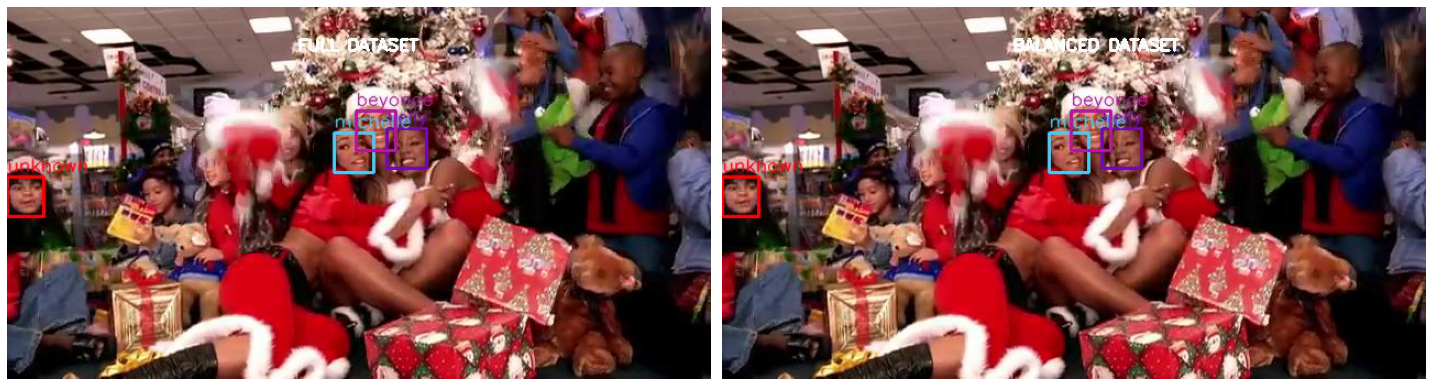

In [ ]:
# Display a reconstruction frame
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
frame_full = os.path.join(MODEL_SAVE_DIR, 'VIDEO_FRAMES', 'FULL', '8_Days_of_Christmas', 'frame_4991.jpg')
frame_balanced = os.path.join(MODEL_SAVE_DIR, 'VIDEO_FRAMES', 'BALANCED', '8_Days_of_Christmas', 'frame_4991.jpg')
ax[0].imshow(plt.imread(frame_full))
ax[0].axis('off')
ax[1].imshow(plt.imread(frame_balanced))
ax[1].axis('off')
plt.tight_layout()
plt.show()

##  Additional Examples, Tutorials and Extended Learning

Checkout the tensorflow [beginner](https://www.tensorflow.org/tutorials/quickstart/beginner) and [advanced](https://www.tensorflow.org/tutorials/quickstart/advanced) tutorials for some quickstart guides!

[Next time,](https://www.youtube.com/channel/UCvVAxOBEAMgu7WwTcFptt-w?sub_confirmation=1) we're going to talk about PyTorch, another popular framework for deep learning. We'll be using this same data with a pre-trained generative adversarial network.